# Bgee

Extracting data from [Bgee](http://bgee.org/). See [this Thinklab discussion](http://thinklab.com/discussion/tissue-specific-gene-expression-resources/81#278) for more information.

In [1]:
import collections
import gzip

import pandas
import seaborn
import numpy
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [22]:
def get_groupby_counts(df, columns):
    """Group datagrame by columns and return the number of rows for each grouping."""
    grouped = df.groupby(columns)
    get_len = lambda df: pandas.Series({'count': len(df)})
    df = grouped.apply(get_len)
    df = df.sort_values('count', ascending=False)
    df = df.reset_index()
    return df

## Load entrez gene for ensembl conversion

In [3]:
# Read Entrez Genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)    
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']

ensembl_to_entrez = dict(zip(entrez_map_df.identifier, entrez_map_df.GeneID))

## Read and process presence of expression data

In [4]:
# Read expression
presence_df = pandas.read_table('download/Homo_sapiens_expr-complete.tsv.gz')
presence_df.head(2)

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Expression,Call quality,Including observed data,Affymetrix data,...,Including Affymetrix observed data,EST data,EST call quality,Including EST observed data,In situ data,In situ call quality,Including in situ observed data,RNA-Seq data,RNA-Seq call quality,Including RNA-Seq observed data
0,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000087,human adult stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no
1,ENSG00000000003,TSPAN6,CL:0000000,cell,HsapDv:0000088,human early adulthood stage (human),present,high quality,no,present,...,no,no data,no data,no,no data,no data,no,no data,no data,no


### Contingency table (as percents) of `Expression` versus `Call quality`

Documentation of Expression and Call Quality is [below](http://bgee.org/?page=doc&action=call_files#single_expr_complete_col7):
> #### Expression (column 7)
Call generated from all data types for Gene ID (column 1), in Anatomical entity ID (column 3), at Developmental stage ID (column 5). One of:
+ **present**: report of presence of expression, from Bgee statistical tests and/or from in situ data sources. See Call quality (column 8) for associated quality level.
+ **absent**: report of absence of expression, from Bgee statistical tests and/or from in situ data sources. In Bgee, calls of absence of expression are always discarded if there exists a contradicting call of expression, from the same data type and for the same gene, in the same anatomical entity and developmental stage, or in a child entity or child developmental stage. See Call quality (column 8) for associated quality level.
+ **low ambiguity**: there exists a call of expression generated from a data type, but there exists a call of absence of expression generated from another data type for the same gene in a parent anatomical entity at the same developmental stage. For instance, gene A is reported to be expressed in the midbrain at young adult stage from Affymetrix data, but is reported to be not expressed in the brain at young adult stage from RNA-Seq data.
+ **high ambiguity**: there exists a call of expression generated from a data type, but there exists a call of absence of expression generated from another data type for the same gene, anatomical entity and developmental stage. For instance, gene A is reported to be expressed in the midbrain at young adult stage from Affymetrix data, but is reported to be not expressed in the midbrain at young adult stage from RNA-Seq data.

> #### Call quality (column 8)
Quality associated to the call in column Expression (column7). One of:
+ **high quality**:
  + In case of report of expression, expression reported as high quality from Bgee statistical tests and/or from in situ data sources, with no contradicting call of absence of expression for same gene, in same anatomical entity and developmental stage (call generated either from multiple congruent data, or from single data).
  + In case of report of absence of expression, call reported as high quality either from Bgee statistical tests and/or from in situ data sources. In Bgee, calls of absence of expression are always discarded if there exists a contradicting call of expression, from the same data type and for the same gene, in the same anatomical entity and developmental stage, or in a child entity or child developmental stage. This is why they are always considered of high quality.
+ **poor quality**: in case of report of expression, expression reported as low quality from Bgee statistical tests and/or from in situ data sources, or because there exists a conflict of presence/absence of expression for the same gene, anatomical entity and developmental stage, from different data of a same type (conflicts between different data types are treated differently, see ambiguity states in column Expression ).
+ **NA**: when the call in column Expression is ambiguous.


In [5]:
pandas.crosstab(presence_df['Call quality'].fillna('NA'), presence_df['Expression']) / len(presence_df)

Expression,absent,high ambiguity,low ambiguity,present
Call quality,,,,
NA,0.000000,0.001063,0.001174,0.000000
high quality,0.105275,0.000000,0.000000,0.665991
poor quality,0.000000,0.000000,0.000000,0.226497


In [6]:
# Apply filters for gene presence
present_df = presence_df[
    presence_df['Expression'].isin({'present'}) &
    presence_df['Call quality'].isin({'high quality'})
]

In [23]:
# Find genes present per developmental stage
stage_df = get_groupby_counts(present_df, ['Developmental stage ID', 'Developmental stage name'])
stage_df.head(12)

,Developmental stage ID,Developmental stage name,count
0,UBERON:0000104,life cycle,7270053
1,UBERON:0000066,fully formed stage,6847848
2,UBERON:0000092,post-embryonic stage,6847848
3,UBERON:0000113,post-juvenile adult stage,6722450
4,HsapDv:0000087,human adult stage (human),6430153
5,HsapDv:0000088,human early adulthood stage (human),5094102
6,HsapDv:0000091,human late adulthood stage (human),5051786
7,HsapDv:0000090,25-44 year-old human stage (human),4821586
8,HsapDv:0000092,human middle aged stage (human),4311395
9,HsapDv:0000093,human aged stage (human),3371418


In [24]:
# Find genes present per anatomical entity
anatomy_df = get_groupby_counts(present_df, ['Anatomical entity ID', 'Anatomical entity name'])
anatomy_df.head(10)

,Anatomical entity ID,Anatomical entity name,count
0,UBERON:0001062,anatomical entity,613385
1,UBERON:0000061,anatomical structure,613367
2,UBERON:0000468,multi-cellular organism,612546
3,UBERON:0000467,anatomical system,580567
4,UBERON:0000064,organ part,452218
5,UBERON:0000990,reproductive system,414926
6,UBERON:0005156,reproductive structure,414926
7,UBERON:0001016,nervous system,411851
8,UBERON:0000475,organism subdivision,410747
9,UBERON:0001017,central nervous system,410621


### Figure 1: Number of genes present by developmental stage and anatomical entity

/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.set_edgecolor(c)


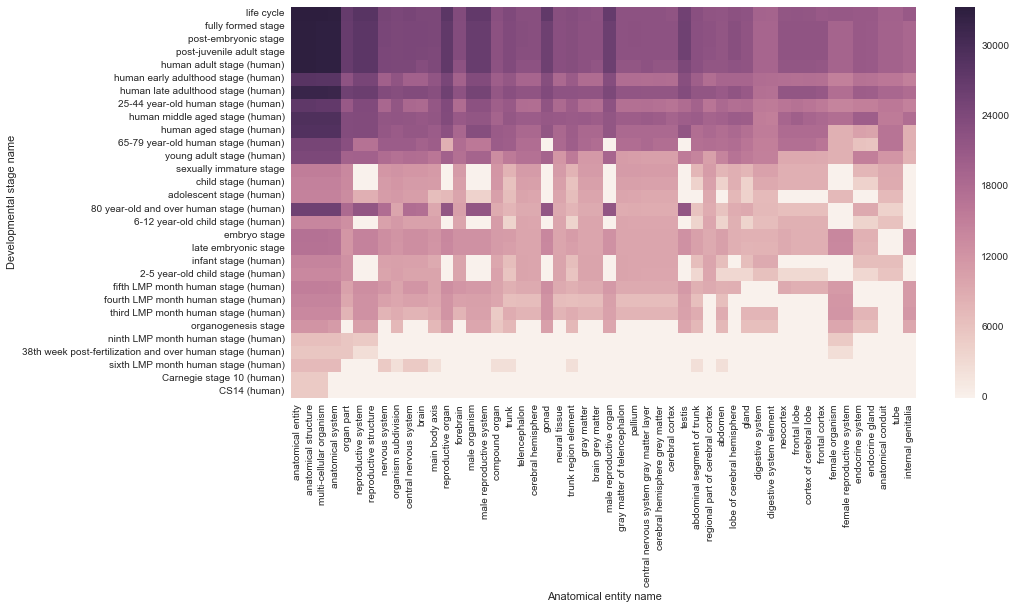

In [9]:
# Number of present genes per development stage -- anatomical entity pair
pairwise_df = get_groupby_counts(present_df, ['Developmental stage name', 'Anatomical entity name'])
rect_df = pairwise_df.pivot('Developmental stage name', 'Anatomical entity name', 'count').fillna(0)
rect_df = rect_df.loc[stage_df['Developmental stage name'][:30], anatomy_df['Anatomical entity name'][:50]]
IPython.core.pylabtools.figsize(14, 7)
seaborn.heatmap(rect_df);

In [10]:
# filter to human adult stage (human)
adult_df = present_df[present_df['Developmental stage ID'] == 'HsapDv:0000087']

# pivot dataframe so each column is an anatomical entity
adult_df = adult_df.pivot('Gene ID', 'Anatomical entity ID', 'Expression')
adult_df = (adult_df == 'present').astype(int)

# convert to entrez GeneIDs
adult_df = adult_df.groupby(ensembl_to_entrez).max()
adult_df = adult_df.reset_index()
adult_df = adult_df.rename(columns=({'index': 'GeneID'}))
adult_df.GeneID = adult_df.GeneID.astype(int)

# save dataframe
with gzip.open('data/present-in-adult.tsv.gz', 'wt') as write_file:
    adult_df.to_csv(write_file, sep='\t', index=False)

# see tail
adult_df.tail()

Anatomical entity ID,GeneID,CL:0000000,CL:0000015,CL:0000019,CL:0000021,CL:0000023,CL:0000064,CL:0000066,CL:0000083,CL:0000115,...,UBERON:0016526,UBERON:0016529,UBERON:0016538,UBERON:0016548,UBERON:0016887,UBERON:0017672,UBERON:0018254,UBERON:0018260,UBERON:0018674,UBERON:3000961
18992,105378753,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
18993,105378933,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18994,105378966,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18995,105379030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18996,105379175,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [11]:
# Coding genes in entrez dataset
len(set(adult_df.GeneID) & coding_genes)

16278

In [12]:
# Frequency of gene presence 
adult_df.drop('GeneID', 1).as_matrix().mean()

0.41120029857725282

## Read and process differential expression data

In [13]:
# Read simple differential expression by anatomy
diffex_df = pandas.read_table('download/Homo_sapiens_diffexpr-anatomy-simple.tsv.gz', compression='gzip')
diffex_df.head(2)

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Differential expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,UBERON:0000113,post-juvenile adult stage,over-expression,low quality
1,ENSG00000000003,TSPAN6,CL:0000738,leukocyte,UBERON:0000113,post-juvenile adult stage,under-expression,high quality


### Contingency table (as percents) of `Differential expression` versus `Call quality`

Documentation of `Differential expression` and `Call quality` is [below](http://bgee.org/?page=doc&action=call_files#single_diff_simple_col7):

> #### Differential expression (column 7)
Call generated from all data types for Gene ID (column 1), in Anatomical entity ID (column 3), at Developmental stage ID (column 5). One of:
+ **over-expression**: the gene was shown in one or more analyses to have a significant over-expression in this condition, as compared to the expression levels in other conditions of the analyses.
+ **under-expression**: the gene was shown in one or more analyses to have a significant under-expression in this condition, as compared to the expression levels in other conditions of the analyses.
+ **weak ambiguity**: there exists a call of over-expression or under-expression generated from a data type, but another data type showed no significant variation of the level of expression of this gene in the same condition; or, a gene was shown to be never expressed in a condition by some analyses of a given data type, but other analyses of different data types produced a call of over-expression or of absence of differential expression for the same gene, in the same condition (note that conflicts where a data type produced an under-expression call in a condition, while another data type showed the same gene to be never expressed in that condition, do not produce a weak ambiguity call, but a call of under-expression low quality).
+ **strong ambiguity**: there exists a call of over-expression or under-expression generated from a data type, but there exists a call in the opposite direction generated from another data type for the same gene, anatomical entity and developmental stage. For instance, gene A is reported to be over-expressed in the midbrain at young adult stage from Affymetrix data, but is reported to be under-expressed in the midbrain at young adult stage from RNA-Seq data.

> #### Call quality (column 8)
Confidence in the differential expression call provided in Differential expression (column 7). One of:
+ **high quality**: differential expression reported as high quality, with no contradicting call from same type of analysis (across anatomy/across life stages), for same gene, in same anatomical entity and developmental stage, (call generated either from multiple congruent analyses, or from a single analysis).
+ **poor quality**: differential expression reported as low quality, or there exists a conflict for the same gene, anatomical entity and developmental stage, from different analyses of a same data type (conflicts between different data types are treated differently). For instance, an analysis showed a gene to be over-expressed in a condition, while another analysis showed the same gene to be under-expressed or not differentially expressed in the same condition. Such conflicts are resolved by a voting system based on the number of conditions compared, weighted by p-value. Note that in one case, this quality level is used to reconcile conflicting calls from different data types: when a data type produced an under-expression call, while a different data type has shown that the same gene was never seen as expressed in the same condition. In that case, the overall summary is under-expression low quality.
+ **NA**: no quality applicable when ambiguity state in Differential expression (column 7).

In [14]:
pandas.crosstab(diffex_df['Call quality'].fillna('NA'), diffex_df['Differential expression']) / len(diffex_df)

Differential expression,high ambiguity,low ambiguity,over-expression,under-expression
Call quality,,,,
NA,0.024854,0.155769,0.000000,0.000000
high quality,0.000000,0.000000,0.211081,0.196327
low quality,0.000000,0.000000,0.176314,0.235655


In [15]:
# filter differential expression
diffex_df = diffex_df[
    diffex_df['Differential expression'].isin({'over-expression', 'under-expression'}) &
    diffex_df['Call quality'].isin({'low quality', 'high quality'})
]

In [25]:
# Calculate counts per anatomy--DE pair
de_anatomy_df = get_groupby_counts(diffex_df, ['Anatomical entity ID', 'Anatomical entity name', 'Differential expression'])
de_anatomy_df.head()

,Anatomical entity ID,Anatomical entity name,Differential expression,count
0,CL:0000738,leukocyte,under-expression,12406
1,UBERON:0000473,testis,over-expression,10267
2,UBERON:0002369,adrenal gland,over-expression,9079
3,UBERON:0000955,brain,over-expression,8485
4,UBERON:0002369,adrenal gland,under-expression,7989


### Figure 2: Number of differntially expressed genes present by anatomical entity

/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.set_edgecolor(c)


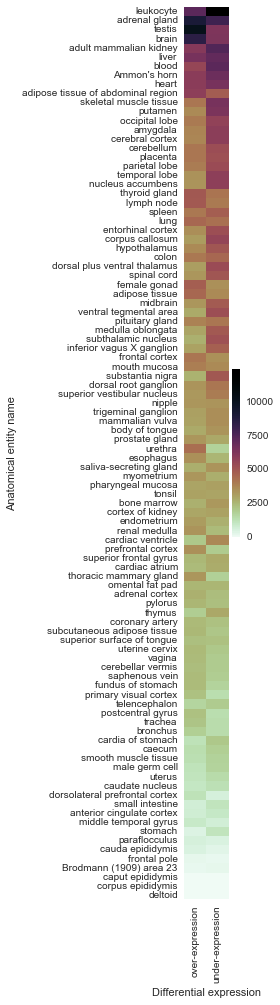

In [17]:
# Plot DE counts
rect_df = de_anatomy_df.pivot('Anatomical entity name', 'Differential expression', 'count').fillna(0)
rect_df['differential expression'] = rect_df['under-expression'] + rect_df['over-expression']
rect_df = rect_df.sort('differential expression', ascending=False)
IPython.core.pylabtools.figsize(1, 16)
cmap = seaborn.cubehelix_palette(15, start=2.2, rot=1, gamma=1.6, hue=1, light=0.98, dark=0, as_cmap=True)
seaborn.heatmap(rect_df.drop('differential expression', axis=1), cmap=cmap);

In [18]:
diffex_pivot_df = diffex_df.pivot('Gene ID', 'Anatomical entity ID', 'Differential expression')
diffex_pivot_df = diffex_pivot_df.replace({'under-expression': -1, 'over-expression': 1, numpy.NaN: 0})

In [19]:
def round_diffex(value):
    if value <= -0.5:
        return -1
    if value >= 0.5:
        return 1
    return 0

diffex_pivot_df = diffex_pivot_df.groupby(ensembl_to_entrez).mean().applymap(round_diffex)

In [20]:
diffex_pivot_df = diffex_pivot_df.reset_index()
diffex_pivot_df = diffex_pivot_df.rename(columns=({'index': 'GeneID'}))
diffex_pivot_df.GeneID = diffex_pivot_df.GeneID.astype(int)

# save dataframe
with gzip.open('data/diffex.tsv.gz', 'wt') as write_file:
    diffex_pivot_df.to_csv(write_file, sep='\t', index=False)

# see tail
diffex_pivot_df.tail()

Anatomical entity ID,GeneID,CL:0000015,CL:0000738,UBERON:0000002,UBERON:0000007,UBERON:0000029,UBERON:0000044,UBERON:0000057,UBERON:0000082,UBERON:0000178,...,UBERON:0005363,UBERON:0007227,UBERON:0007318,UBERON:0007371,UBERON:0007808,UBERON:0009834,UBERON:0009835,UBERON:0010414,UBERON:0011876,UBERON:0013554
18615,105378753,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18616,105378933,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18617,105378966,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18618,105379030,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18619,105379175,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Coding genes in entrez dataset
len(set(diffex_pivot_df.GeneID) & coding_genes)

16184